# Th1/Th2 polarization signature

Data source: 
- Ota et al., Cell 2021 
- [Hollbacher et al., Immunohorizons 2021](https://academic.oup.com/immunohorizons/article/4/10/585/7820541?login=true)
- in-house Diff043 scRNAseq

In [33]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

from scipy.stats import pearsonr

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

To download processed data on dropbox:
```bash
DATADIR=/mnt/oak/users/emma/data/GWT/polarization_datasets/
mkdir -p $DATADIR

# Ron scRNA-seq
DROPBOX_PATH=GRNPerturbSeq/3_expts/Diff035scRNAseq/
rclone copy dropbox:${DROPBOX_PATH}Diff035_pseudobulk.h5ad ${DATADIR} --checksum --ignore-times
rclone copy dropbox:${DROPBOX_PATH}Diff035_merged.gex.filtered.h5ad ${DATADIR} --checksum --ignore-times

# Published datasets
DROPBOX_PATH=GRNPerturbSeq/2_files/
rclone copy dropbox:${DROPBOX_PATH}Ota_et_al_2021/ ${DATADIR}Ota_et_al_2021 --checksum --ignore-times -v
mkdir -p $DATADIR/Hollbacher_et_al_2021
rclone copy dropbox:${DROPBOX_PATH}Hollbacher_et_al_2021/ $DATADIR/Hollbacher_et_al_2021/ --checksum --ignore-times -v
```

### Process Hollbacher et al 2021 RNAseq

In [2]:
DATADIR = '/mnt/oak/users/emma/data/GWT/polarization_datasets/'

In [3]:
hollbacher_df = pd.read_csv(f'{DATADIR}/Hollbacher_et_al_2021/Hollbacher_et_al_raw_counts.csv', index_col=0)

In [5]:
# Parse into anndata in preparation for DESeq2
obs_metadata = pd.DataFrame({'donor_id': [item[0] for item in hollbacher_df.columns.str.split('_')],
                            'cell_subset': [item[1] for item in hollbacher_df.columns.str.split('_')]},
                            index=hollbacher_df.columns)
adata_hollbacher = anndata.AnnData(X=hollbacher_df.T.astype(int),
                                   obs=obs_metadata,
                                   var=pd.DataFrame({'gene_name': hollbacher_df.index},
                                                     index=hollbacher_df.index))
adata_hollbacher.var['mean_expression'] = adata_hollbacher.X.mean(axis=0)
#adata_hollbacher = adata_hollbacher[:, adata_hollbacher.var['mean_expression'] > 10].copy()

In [10]:
adata_hollbacher.obs.donor_id.nunique()

3

In [5]:
sc.pp.pca(adata_hollbacher)
pcs = adata_hollbacher.obsm['X_pca'][:,:10]
pc_df = pd.DataFrame(pcs,
                     index=adata_hollbacher.obs_names,
                     columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                             'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
adata_hollbacher.obs = pd.concat([adata_hollbacher.obs, pc_df], axis=1)

In [6]:
adata_hollbacher.obs.cell_subset.unique()

array(['Th17', 'Th22', 'Th2', 'Th1/17', 'Th1', 'Naive', 'Treg17',
       'Treg22', 'Treg2', 'Treg1/17', 'Treg1'], dtype=object)

In [7]:
model = pertpy.tl.PyDESeq2(adata_hollbacher, design='~cell_subset+donor_id+PC1')
model.fit(quiet=True)

# Create a list to store all result dataframes
result_dfs = []

for subset in ['Th2']:
    test_st = subset
    control_st = 'Th1'
    polariz_contrast = (model.cond(cell_subset=test_st) - model.cond(cell_subset=control_st)) 
    res_df = model.test_contrasts(polariz_contrast)
    res_df['contrast'] = test_st + '_vs_' + control_st
    # Store the result dataframe in our list
    result_dfs.append(res_df)

all_results_hollbacher_df = pd.concat(result_dfs)

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:380: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:234: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:232: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:384: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:387: RuntimeWarning: invalid value encountered in divide
  + ((1 / disp + counts) * mu_ / (1 / disp +

Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
                                                                           
A1BG      60.401506        0.690717  0.268060  2.576725  0.009974  0.145776
AAAS     236.956091       -0.100342  0.142025 -0.706506  0.479874  0.907945
AACS     166.055195       -0.062094  0.161143 -0.385336  0.699988  0.967729
AAED1    290.132645        0.261344  0.227804  1.147233  0.251286  0.783194
AAGAB    417.375987       -0.074158  0.099946 -0.741986  0.458096  0.898734
...             ...             ...       ...       ...       ...       ...
ZYG11A     9.088249       -0.256005  0.579211 -0.441988  0.658498  0.962136
ZYG11B   502.647468        0.012023  0.132184  0.090956  0.927528  0.998439
ZYX     2269.454502        0.505421  0.155465  3.251029  0.001150  0.029706
ZZEF1   2934.792766       -0.041094  0.138004 -0.29

... done in 0.79 seconds.



In [8]:
all_results_hollbacher_df[all_results_hollbacher_df.variable=='IFNGR2']

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
61,IFNGR2,219.236197,1.496207,0.232109,6.446138,1.147362e-10,2.307123e-08,Th2_vs_Th1


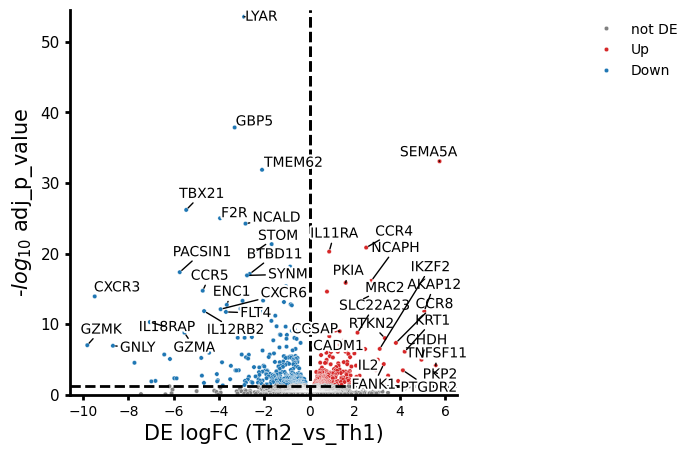

In [10]:
res_df = all_results_hollbacher_df[all_results_hollbacher_df.contrast=='Th2_vs_Th1'].copy()
p = res_df['contrast'].iloc[0]
model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    s=10,
    x_label=f"DE logFC ({p})",
    to_label = 20,
    )

In [11]:
all_results_hollbacher_df['zscore'] = all_results_hollbacher_df['log_fc'] / all_results_hollbacher_df['lfcSE']
all_results_hollbacher_df.to_csv("results/hollbacher_Th2vsTh1_DE_results.csv", index=False)

### Process Ota et al 2021 RNAseq

In [12]:
# Load sample information, memory CD4, Th1 and Th2 RNAseq
sample_info = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/clinical_diagnosis_age_sex_v2.txt', delimiter='\t')
ota_Th1 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Th1_count.txt', delimiter='\t')
ota_Th2 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Th2_count.txt', delimiter='\t')
ota_naive = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Naive_CD4_count.txt', delimiter='\t')
ota_mem = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Mem_CD4_count.txt', delimiter='\t')
ota_Th17 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Th17_count.txt', delimiter='\t')
ota_Tfh = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Tfh_count.txt', delimiter='\t')
ota_all = [ota_Th1, ota_Th2, ota_naive, ota_mem, ota_Th17, ota_Tfh]

# Select phase 2 healthy control samples
mask = (sample_info.disease=='HC') & (sample_info.Phase==2)
sample_HC_p2 = sample_info[mask].id.values
sample_common = set(sample_HC_p2)

# Find common samples across all subsets
for sample in ota_all:
    sample_common = sample_common & set(sample.columns)

sample_common = list(sample_common)
columns_to_get = ['Gene_id', 'Gene_name'] + sample_common

for i, sample in enumerate(ota_all):
    ota_all[i] = sample[columns_to_get].copy()

# Parse into anndata in preparation for DESeq2
cell_subset = ['Th1', 'Th2', 'naive', 'memory', 'Th17', 'Tfh']
obs_metadata = pd.DataFrame({'cell_subset': cell_subset[0],
                             'donor_id': ota_all[0].columns[2:]},
                            index=cell_subset[0]+'_'+ota_all[0].columns[2:])
adata_ota = anndata.AnnData(X=ota_all[0].iloc[:,2:].T.reset_index(drop=True),
                            obs=obs_metadata,
                            var=ota_all[0].iloc[:,:2])

for i, sample in enumerate(ota_all[1:]):
    obs_metadata = pd.DataFrame({'cell_subset': cell_subset[i+1],
                                 'donor_id':sample.columns[2:]},
                                index=cell_subset[i+1]+'_'+sample.columns[2:])
    adata_temp = anndata.AnnData(X=sample.iloc[:,2:].T.reset_index(drop=True),
                                obs=obs_metadata,
                                var=sample.iloc[:,:2])
    adata_ota = ad.concat([adata_ota, adata_temp])

adata_ota.var = ota_all[0].iloc[:,:2].copy()
adata_ota.var.index = adata_ota.var['Gene_name']
adata_ota.var_names_make_unique()
obs_temp = adata_ota.obs.copy()
obs_update = pd.merge(obs_temp, sample_info, how='inner', left_on='donor_id', right_on='id')
obs_update = obs_update[['cell_subset', 'donor_id', 'age', 'sex']]
obs_update.index = adata_ota.obs.index
adata_ota.obs = obs_update.copy()
sc.pp.filter_genes(adata_ota, min_counts=100)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:268: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3', 'SNORD113-5', 'SNORD113-6']
  warnings.warn(


In [13]:
sc.pp.pca(adata_ota)
pcs = adata_ota.obsm['X_pca'][:,:10]
pc_df = pd.DataFrame(pcs,
                     index=adata_ota.obs_names,
                     columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                             'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
adata_ota.obs = pd.concat([adata_ota.obs, pc_df], axis=1)

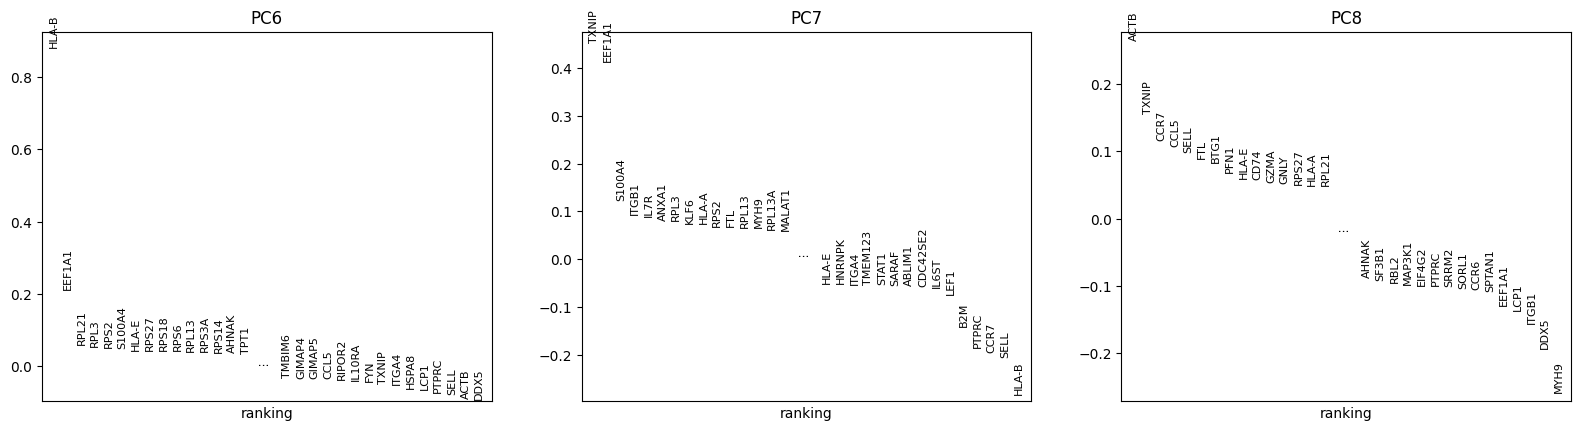

In [14]:
sc.pl.pca_loadings(adata_ota, components='6,7,8')

In [17]:
# flex_gene_df = pd.read_csv(f'{DATADIR}/Chromium_Human_Transcriptome_Probe_Set_v1.1.0_GRCh38-2024-A_notitle.csv')
# flex_gene = flex_gene_df[flex_gene_df.included==True].gene_name.unique()
# len(flex_gene), len(set(flex_gene)&set(adata_ota.var.Gene_name.values)), len(set(adata_ota.var.Gene_name.values))

In [18]:
adata_ota.obs.cell_subset.unique()

array(['Th1', 'Th2', 'naive', 'memory', 'Th17', 'Tfh'], dtype=object)

In [77]:
adata_ota

AnnData object with n_obs × n_vars = 378 × 24821
    obs: 'cell_subset', 'donor_id', 'age', 'sex', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'size_factors', 'replaceable'
    var: 'Gene_id', 'Gene_name', 'n_counts', '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    uns: 'pca', 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'X_pca', 'design_matrix', '_mu_LFC', '_hat_diagonals'
    varm: 'PCs', 'LFC'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [19]:
model = pertpy.tl.PyDESeq2(adata_ota, design='~cell_subset+PC1+PC2')
model.fit(quiet=True)

# Create a list to store all result dataframes
result_dfs = []

for subset in ['Th2']:
    test_st = subset
    control_st = 'Th1'
    polariz_contrast = (model.cond(cell_subset=test_st) - model.cond(cell_subset=control_st)) 
    res_df = model.test_contrasts(polariz_contrast)
    res_df['contrast'] = test_st + '_vs_' + control_st
    # Store the result dataframe in our list
    result_dfs.append(res_df)

all_results_ota_df = pd.concat(result_dfs)

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:380: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:234: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:232: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:384: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/utils.py:387: RuntimeWarning: invalid value encountered in divide
  + ((1 / disp + counts) * mu_ / (1 / disp +

Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  1.  0.  0.  0.  0.]
              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
Gene_name                                                                   
DPM1        509.149188        0.053026  0.027243   1.946422  5.160406e-02   
SCYL3       452.920560        0.069168  0.030484   2.268944  2.327175e-02   
C1orf112     91.382905        0.185970  0.057860   3.214144  1.308340e-03   
FGR         101.401593       -4.884158  0.316217 -15.445584  8.079304e-54   
CFH         191.970461       -2.292555  0.376881  -6.082969  1.179772e-09   
...                ...             ...       ...        ...           ...   
AC099063.4   81.240089       -0.492712  0.048895 -10.076984  6.983703e-24   
AL139424.3    2.159751       -0.235192  0.218795  -1.074942  2.824008e-01   
AL358472.5    7.220517       -0.144415  0.125580  -1.149985  2.501500e-01   
AL645728.2    0.441464       -0.124228  0.462413  -0.268651  7.8

... done in 1.35 seconds.



NaNs encountered, dropping rows with NaNs
0s encountered for p value, replacing with 1e-323


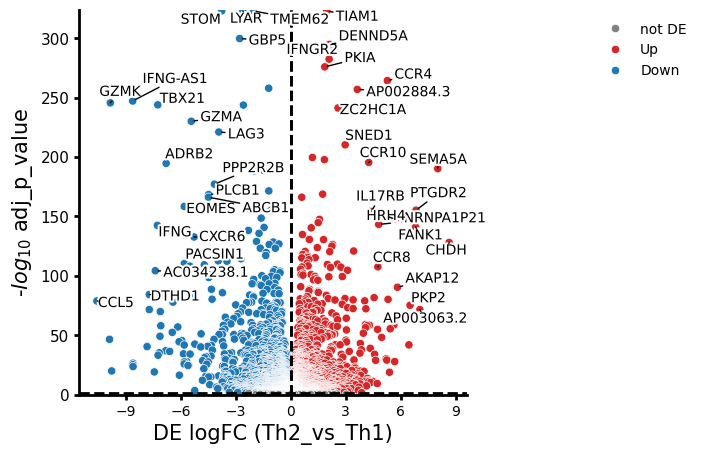

In [24]:
res_df = all_results_ota_df[all_results_ota_df.contrast=='Th2_vs_Th1'].copy()
p = res_df['contrast'].iloc[0]
model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    x_label=f"DE logFC ({p})",
    to_label = 20
    )

In [27]:
all_results_ota_df['zscore'] = all_results_ota_df['log_fc']/all_results_ota_df['lfcSE']
all_results_ota_df.to_csv("results/Ota_Th2vsTh1_DE_results.csv", index=False)

## DE analysis on polarization experiments

In [30]:
# adata_Th1 = sc.read_h5ad(f'{DATADIR}/Diff043scRNAseq/Diff043_Th1_merged.gex.filtered.h5ad')
# adata_Th2 = sc.read_h5ad(f'{DATADIR}/Diff043scRNAseq/Diff043_Th2_merged.gex.filtered.h5ad')
# adata = ad.concat([adata_Th1, adata_Th2])
# adata.var = adata_Th1.var.copy()
# adata.obs['sample_id'] = adata.obs.timepoint.astype(str) + '_' + adata.obs.donor.astype(str) + '_' + adata.obs.culture_condition.astype(str)
# sc.pp.filter_genes(adata, min_cells=1000)

In [31]:
# unique_conditions = adata.obs['sample_id'].unique()

# train_indices = []
# test_indices = []
# # Split each condition separately to maintain balance
# for condition in unique_conditions:
#     condition_indices = adata.obs[adata.obs['sample_id'] == condition].index
#     train_idx, test_idx = train_test_split(
#         condition_indices,
#         test_size=0.25,
#         random_state=42
#     )
#     train_indices.extend(train_idx)
#     test_indices.extend(test_idx)

# adata.obs['split'] = 'train'
# adata.obs.loc[test_indices, 'split'] = 'test'

# print(adata.obs.groupby(['sample_id', 'split']).size().unstack())

In [32]:
# # Pseudobulking and feature selection
# adata_train = adata[adata.obs['split'] == 'train'].to_memory()
# pbulk_adata = sc.get.aggregate(adata_train, by=['timepoint', 'donor', 'culture_condition'], func=['sum'])

# # Filter out lowly expressed genes
# #pbulk_adata.var['mean_expression'] = pbulk_adata.layers['sum'].mean(axis=0)
# #pbulk_adata = pbulk_adata[:, pbulk_adata.var['mean_expression'] > 1].copy()
# # Filter out mitochrondria genes
# pbulk_adata = pbulk_adata[:,~pbulk_adata.var.gene_name.str.startswith('MT-')].copy()
# pbulk_adata.X = pbulk_adata.layers['sum'].copy()

# # Process test dataset
# adata_test = adata[adata.obs['split'] == 'test'].to_memory()
# adata_test = adata_test[:, pbulk_adata.var_names].copy()
# pbulk_adata_test = sc.get.aggregate(adata_test, by=['timepoint', 'donor', 'culture_condition'], func=['sum'])
# pbulk_adata_test.X = pbulk_adata_test.layers['sum'].copy()

In [33]:
# tps = ['Rest', 'Stim8hr', 'Stim48hr']
# result_dfs = []
# repl_result_dfs = []

# for tp in tps:
#     tp_mask = adata.obs['timepoint']==tp
#     pbulk_adata_subset = pbulk_adata[pbulk_adata.obs.timepoint==tp].copy()
#     pbulk_adata_test_subset = pbulk_adata_test[pbulk_adata_test.obs.timepoint==tp].copy()

#     # Fit DESeq2 model
#     model = pertpy.tl.PyDESeq2(pbulk_adata_subset, design='~donor+culture_condition', layer='sum')
#     model.fit(quiet=True)
#     polariz_contrast = (model.cond(culture_condition='Th2') - model.cond(culture_condition='Th1')) 
#     res_df = model.test_contrasts(polariz_contrast)
#     res_df['contrast'] = 'Th2_vs_Th1_' + tp
#     # Store the result dataframe in our list
#     result_dfs.append(res_df)
    
#     # Fit DESeq2 model
#     model = pertpy.tl.PyDESeq2(pbulk_adata_test_subset, design='~donor+culture_condition', layer='sum')
#     model.fit(quiet=True)
#     polariz_contrast = (model.cond(culture_condition='Th2') - model.cond(culture_condition='Th1')) 
#     res_df = model.test_contrasts(polariz_contrast)
#     res_df['contrast'] = 'Th2_vs_Th1_' + tp
#     # Store the result dataframe in our list
#     repl_result_dfs.append(res_df)

In [34]:
# tps = ['Rest', 'Stim8hr', 'Stim48hr']
# states = ['Mix', 'Th1', 'Th2']
# result_dfs = []
# repl_result_dfs = []

# for tp in tps:
#     tp_mask = adata.obs['timepoint']==tp
#     pbulk_adata_subset = pbulk_adata[pbulk_adata.obs.timepoint==tp].copy()
#     pbulk_adata_test_subset = pbulk_adata_test[pbulk_adata_test.obs.timepoint==tp].copy()

#     for st in states:
#         # Fit DESeq2 model
#         model = pertpy.tl.PyDESeq2(pbulk_adata_subset, design='~donor+culture_condition', layer='sum')
#         model.fit(quiet=True)
#         polariz_contrast = (model.cond(culture_condition=st) - model.cond(culture_condition='Th0')) 
#         res_df = model.test_contrasts(polariz_contrast)
#         res_df['contrast'] = st + '_vs_Th0_' + tp
#         # Store the result dataframe in our list
#         result_dfs.append(res_df)
        
#         # Fit DESeq2 model
#         model = pertpy.tl.PyDESeq2(pbulk_adata_test_subset, design='~donor+culture_condition', layer='sum')
#         model.fit(quiet=True)
#         polariz_contrast = (model.cond(culture_condition=st) - model.cond(culture_condition='Th0')) 
#         res_df = model.test_contrasts(polariz_contrast)
#         res_df['contrast'] = st + '_vs_Th0_' + tp
#         # Store the result dataframe in our list
#         repl_result_dfs.append(res_df)

In [48]:
# #all_results_df = pd.read_csv("results/discovery_polarization_DE_results.csv")
# all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']

# #all_repl_results_df = pd.read_csv("results/replication_polarization_DE_results.csv")
# all_repl_results_df['zscore'] = all_repl_results_df['log_fc']/all_repl_results_df['lfcSE']

# # Compare z-scores between discovery and replication results for each condition
# conditions = ['Th2_vs_Th1_Rest', 'Th2_vs_Th1_Stim8hr', 'Th2_vs_Th1_Stim48hr', ]

# fig, ax = plt.subplots(1,3,figsize=(12,3))
# ax = ax.flatten()
# for i, cond in enumerate(conditions):
#     # Get discovery and replication results for this condition
#     disc_results = all_results_df[all_results_df['contrast'] == cond]
#     repl_results = all_repl_results_df[all_repl_results_df['contrast'] == cond]
    
#     # Merge on gene name to compare z-scores
#     merged = pd.merge(disc_results, repl_results, 
#                      on='variable', 
#                      suffixes=('_disc', '_repl'))
    
#     ax[i].scatter(merged['zscore_disc'], merged['zscore_repl'], alpha=0.5)
#     ax[i].set_xlabel(f'Discovery Z-score ({cond})')
#     ax[i].set_ylabel(f'Replication Z-score ({cond})')
    
#     # Add correlation coefficient
#     corr = merged['zscore_disc'].corr(merged['zscore_repl'])
#     ax[i].set_title(f'{cond} vs Th0\nCorrelation: {corr:.3f}')
    
#     # Add diagonal line
#     min_val = min(merged['zscore_disc'].min(), merged['zscore_repl'].min())
#     max_val = max(merged['zscore_disc'].max(), merged['zscore_repl'].max())
#     ax[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    
# plt.tight_layout()
# plt.show()

In [11]:
all_results_diff043_df = pd.read_csv("results/Diff043_Th2vsTh1_DE_results.csv")
all_results_ota_df = pd.read_csv("results/Ota_Th2vsTh1_DE_results.csv")
all_results_hollbacher_df = pd.read_csv("results/hollbacher_Th2vsTh1_DE_results.csv")

In [3]:
activation_signature = pd.read_csv('Arce2024_20230130_DESeq2_output_AAVS1_Teff_Stimulation_vs_Resting.csv').dropna()
activation_signature = activation_signature.rename(columns={'log2FoldChange':'log_fc', 'padj':'adj_p_value', 'gene_name':'variable'})
activation_signature['zscore'] = activation_signature['log_fc']/activation_signature['lfcSE']

## Comparison of polarization signatures

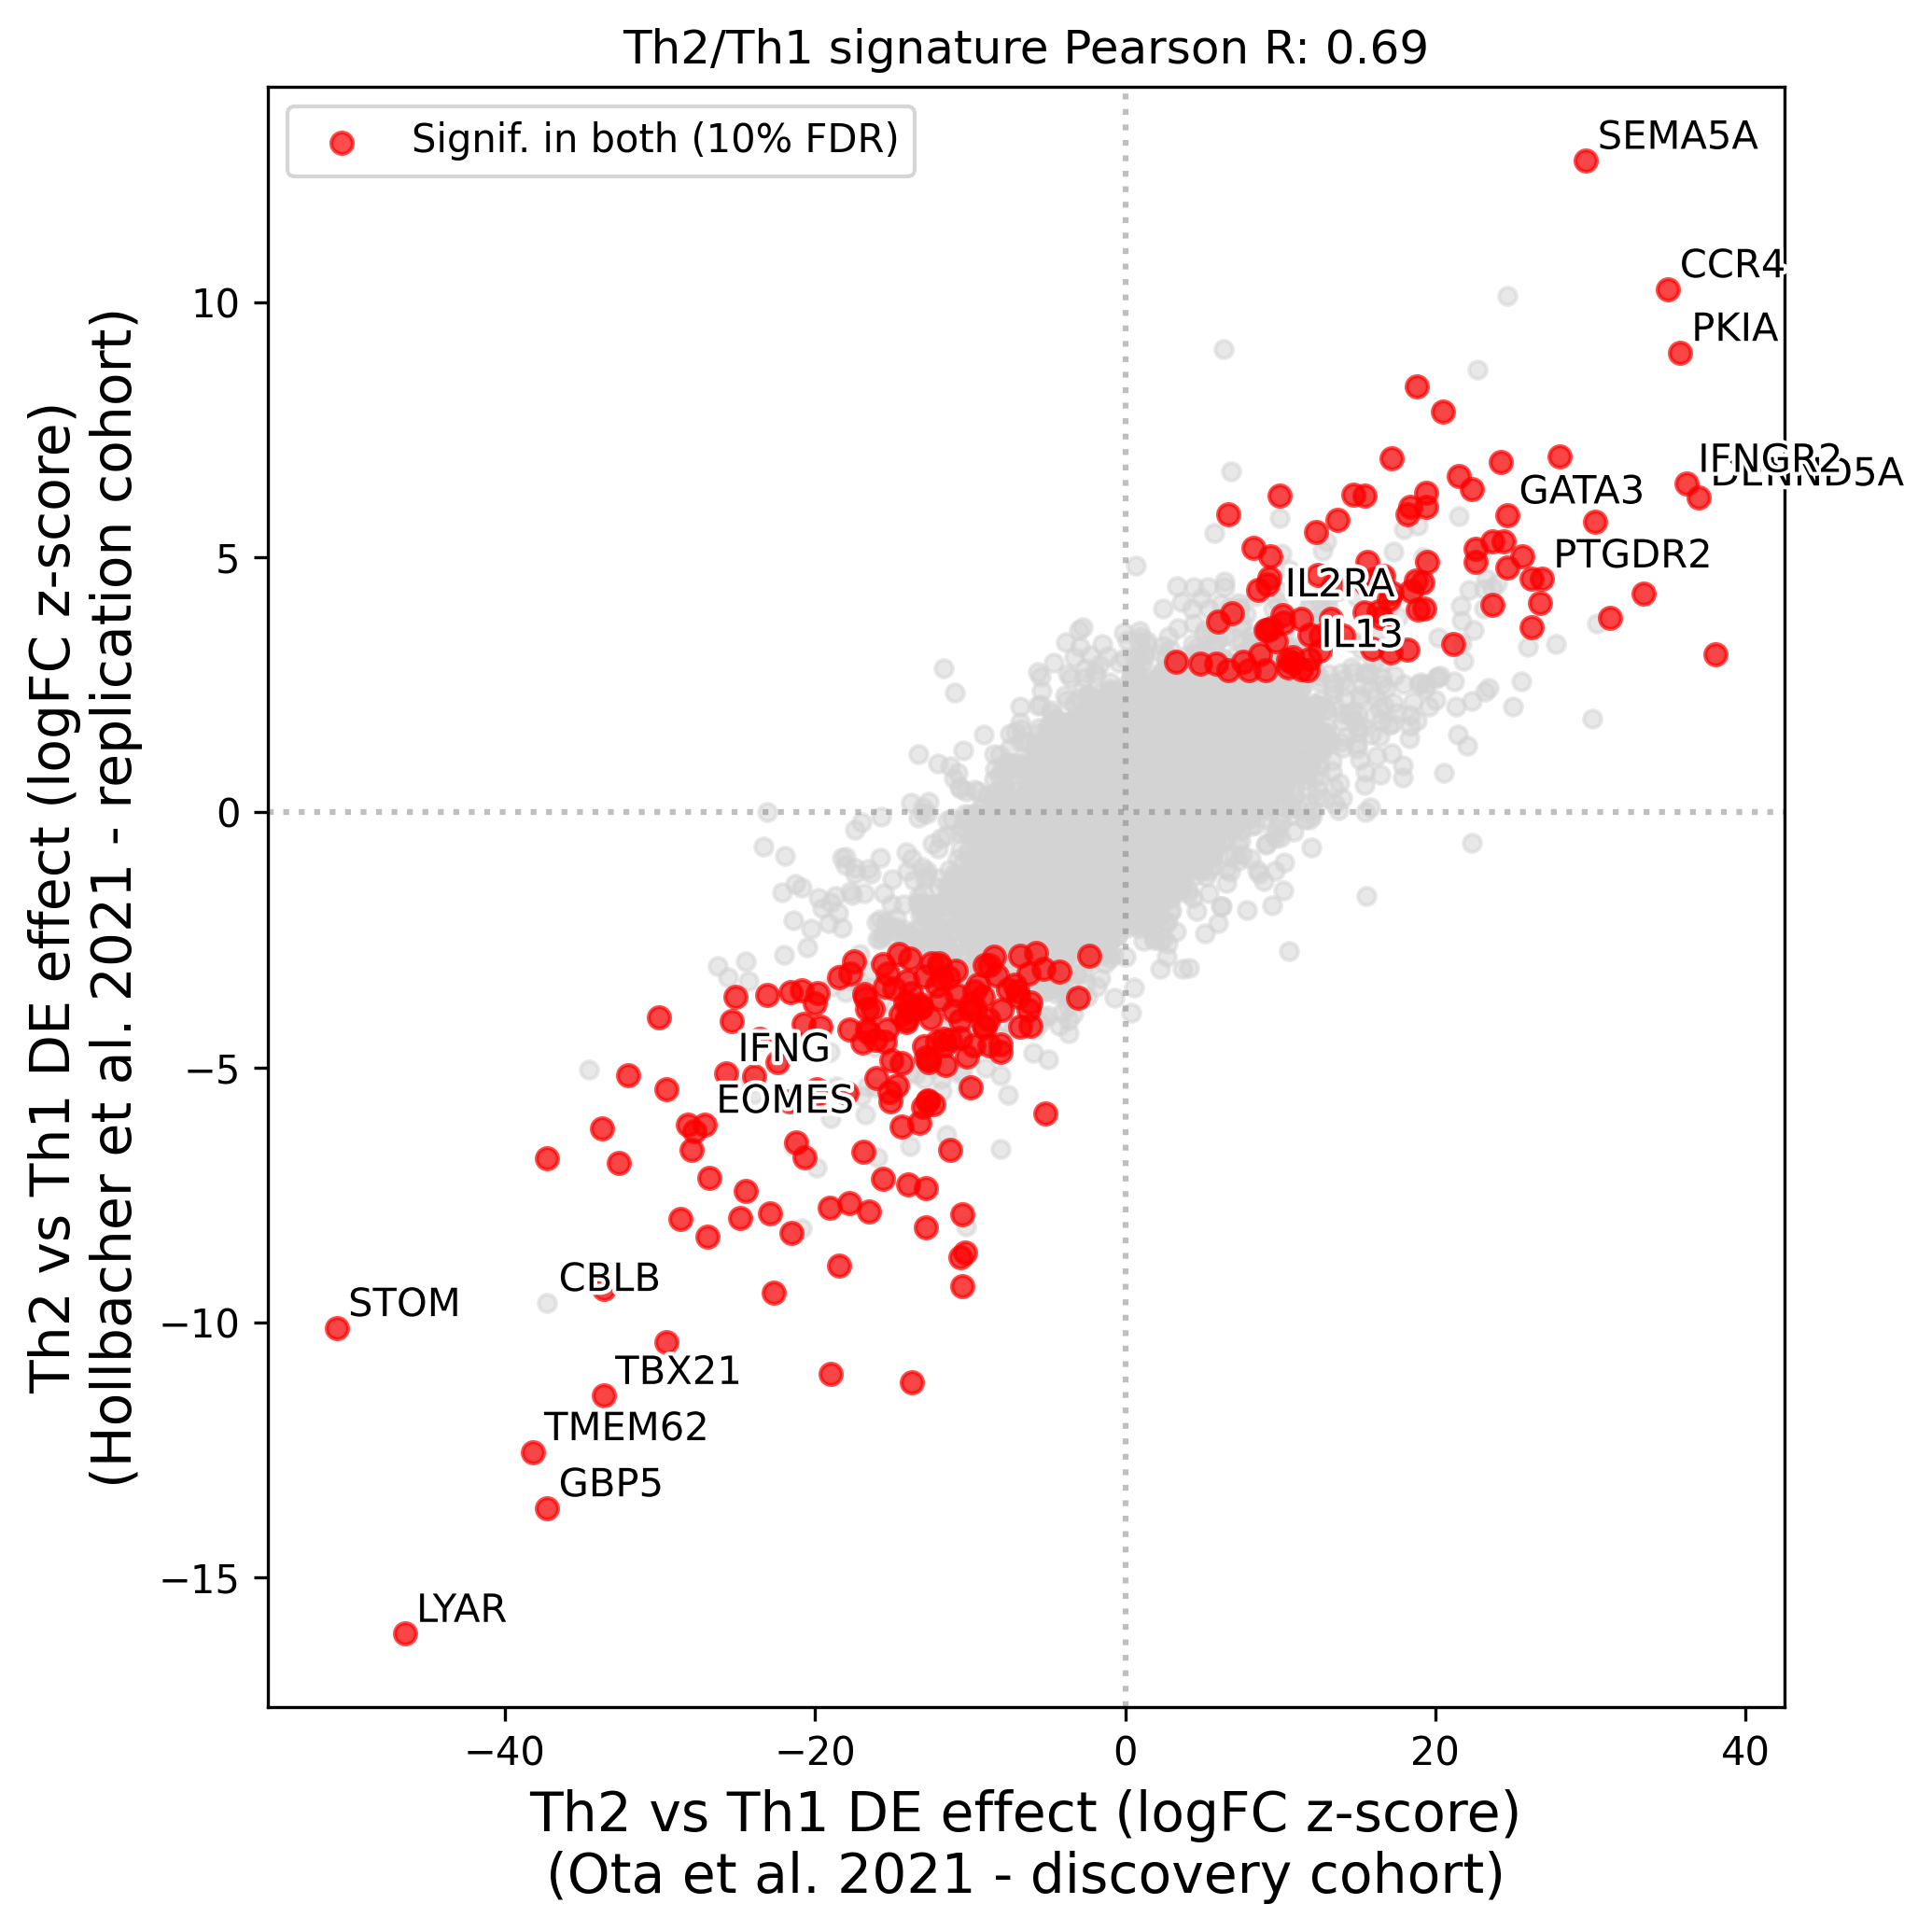

In [41]:
signif_thres = 1
test = pd.merge(all_results_ota_df[all_results_ota_df.adj_p_value<=signif_thres][['variable', 'zscore', 'log_fc', 'adj_p_value']],
                all_results_hollbacher_df[['variable', 'zscore', 'log_fc', 'adj_p_value']],
                left_on='variable',
                right_on='variable')
test = test.fillna(0)
test

plt.figure(figsize=(7,7))

# Plot all points in grey
plt.scatter(test['zscore_x'], test['zscore_y'], color='lightgrey', alpha=0.5, s=20, rasterized=True)

# Add points significant in both datasets
signif_both = (test['adj_p_value_x'] < 0.1) & (test['adj_p_value_y'] < 0.1) & (abs(test['log_fc_x']) > 1) & (abs(test['log_fc_y']) > 1)
plt.scatter(test.loc[signif_both, 'zscore_x'], test.loc[signif_both, 'zscore_y'],
           color='red', alpha=0.7, s=30, label='Signif. in both (10% FDR)', rasterized=True)

# Get top/bottom genes by total zscore
n_top = 5
test['total_zscore'] = test['zscore_x'] + test['zscore_y']
top_genes = test.nlargest(n_top, 'total_zscore')
bottom_genes = test.nsmallest(n_top, 'total_zscore')
# Add selected genes to annotate
selected_genes = ['TBX21', 'GATA3', 'EOMES', 'FOXP3', 'IL2RA', 'IFNG', 'IL4', 'PTGDR2','IL13', 'IL5']
selected = test[test['variable'].isin(selected_genes)]
# plt.scatter(selected['zscore_x'], selected['zscore_y'], 
#            color='blue', alpha=0.7, s=50, label='Selected genes')

# Annotate these genes with adjust_text to avoid overlaps
texts = []
for _, gene in pd.concat([top_genes, bottom_genes, selected]).iterrows():
    texts.append(plt.annotate(gene['variable'],
                xy=(gene['zscore_x'], gene['zscore_y']),
                xytext=(3, 3),
                textcoords='offset points',
                fontsize=10,
                path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2, foreground='white')]))

# Add dotted lines at x=0 and y=0
plt.axhline(y=0, color='grey', linestyle=':', alpha=0.5)
plt.axvline(x=0, color='grey', linestyle=':', alpha=0.5)

# Add labels
plt.xlabel('Th2 vs Th1 DE effect (logFC z-score)\n(Ota et al. 2021 - discovery cohort)', fontsize=14)
plt.ylabel('Th2 vs Th1 DE effect (logFC z-score)\n(Hollbacher et al. 2021 - replication cohort)', fontsize=14)
plt.legend()

# Calculate correlation and add to plot title
corr, pval = pearsonr(test['zscore_x'], test['zscore_y'])
plt.title(f'Th2/Th1 signature Pearson R: {corr:.2f}')

plt.tight_layout()
plt.savefig('./results/Ota_vs_Hollbacher_signature.pdf')
plt.savefig('./results/Ota_vs_Hollbacher_signature.png')

In [67]:
all_results_ota_df['contrast'] = 'Th2_vs_Th1 (Ota 2021)'
all_results_hollbacher_df['contrast'] = 'Th2_vs_Th1 (Hollbacker 2021)'

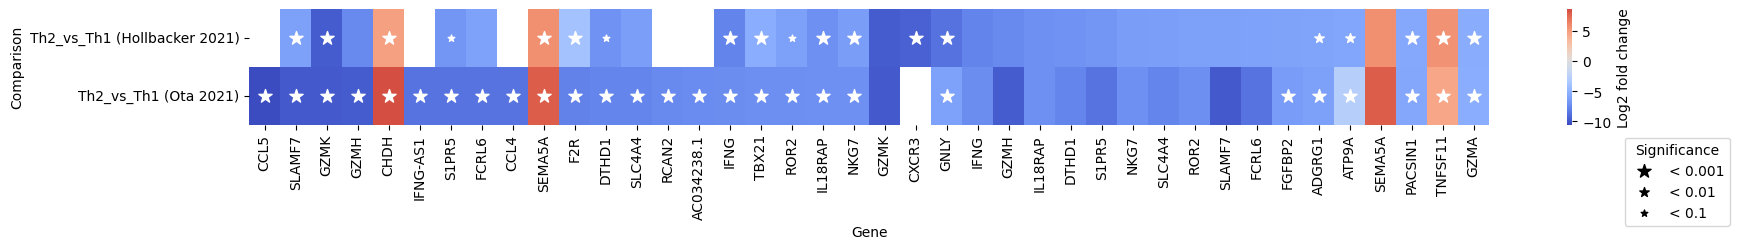

In [68]:
all_results = pd.concat([all_results_ota_df, all_results_hollbacher_df])
all_results['adj_p_value'] = all_results['adj_p_value'].fillna(1)
model.plot_multicomparison_fc(all_results, figsize=(20, 1.5), n_top_vars=20, xticklabels=True, x_label = "Gene", y_label='Comparison')

Compare with starCAT annotation

In [16]:
tcat.ref['TBX21'].sort_values()

Treg                     0.000000
SOX4/TOX2                0.000000
Doublet-Fibroblast       0.000000
IEG3                     0.000000
CD172a/MERTK             0.000000
Doublet-Bcell            0.000000
Th2-Resting              0.000000
Th2-Activated            0.000000
BCL2/FAM13A              0.000000
Doublet-Plasmablast      0.000000
CD8-Naive                0.000000
Th17-Resting             0.000000
CD4-Naive                0.000000
CD4-CM                   0.000000
Doublet-Myeloid          0.000000
Tfh-1                    0.000000
Cytoskeleton             0.000000
Translation              0.000000
NME1/FABP5               0.000000
Th22                     0.000000
Th17-Activated           1.307698
IL10/IL19                1.552729
Mito                     2.405960
ICOS/CD38                3.192168
CellCycle-S              9.096344
Tfh-2                    9.497932
CellCycle-Late-S        12.806239
CTLA4/CD38              14.303215
RGCC/MYADM              15.290133
Poor-Quality  

In [ ]:
tcat.ref['STOM'].

Th1-Like               290.414520
CD8-Trm                170.248779
CD8-EM                 165.571777
gdT                    162.553162
CD40LG/TXNIP           146.395660
Tph                    140.289932
Cytotoxic              136.994339
ISG                    134.218811
TEMRA                  128.770432
MAIT                   113.793465
Multi-Cytokine         111.389229
Th17-Resting            86.553452
Heatshock               76.355797
Doublet-Platelet        64.601273
RGCC/MYADM              60.711208
Poor-Quality            56.093067
Th17-Activated          54.420593
CD4-CM                  48.372540
IEG2                    44.023628
TIMD4/TIM3              41.983639
IEG                     39.867813
Doublet-Bcell           37.885101
Cytoskeleton            34.154179
Doublet-RBC             33.028667
CellCycle-G2M           32.558777
HLA                     32.505283
CellCycle-S             31.890425
CD172a/MERTK            20.777691
Th22                    17.794699
CellCycle-Late

Using reference from starCAT database
Loading reference from existing cache file for reference TCAT.V1


Text(0, 0.5, 'Differential Expression Z-score\n(Th2 vs Th1)')

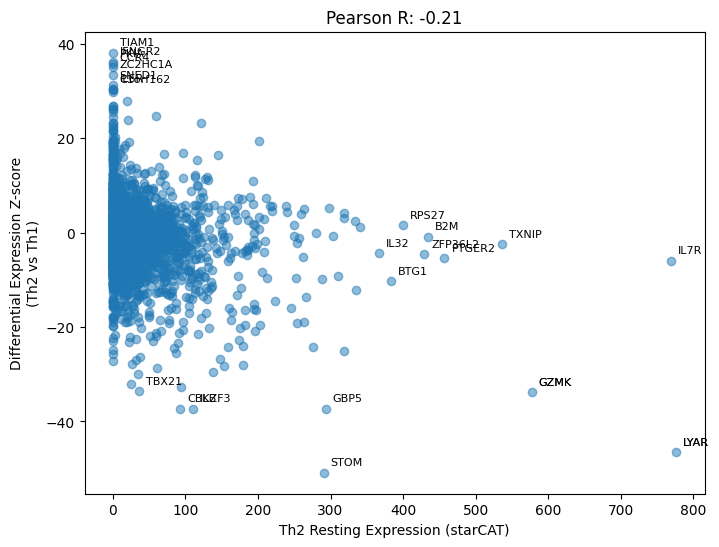

In [27]:
import starcat
tcat = starcat.starCAT(reference='TCAT.V1')
# Get Th2-Resting values for genes in all_results_ota_df that exist in tcat.ref
th2_values = tcat.ref.loc['Th1-Like'][all_results_ota_df.variable[all_results_ota_df.variable.isin(tcat.ref.columns)]]

# Add values as new column to all_results_ota_df
all_results_ota_df['th2_resting_expr'] = all_results_ota_df.variable.map(th2_values)
# Create scatter plot of zscore vs Th2 resting expression
plt.figure(figsize=(8,6))
plt.scatter(all_results_ota_df.th2_resting_expr, all_results_ota_df.zscore, alpha=0.5)

# Calculate correlation and add to plot title
corr = np.corrcoef(all_results_ota_df.th2_resting_expr.dropna(), all_results_ota_df.zscore[all_results_ota_df.th2_resting_expr.notna()])[0,1]
plt.title(f'Pearson R: {corr:.2f}')

# Get top points to annotate
n_points = 10
top_expr = all_results_ota_df.nlargest(n_points, 'th2_resting_expr')
top_zscore = all_results_ota_df.nlargest(n_points, 'zscore')
bottom_zscore = all_results_ota_df.nsmallest(n_points, 'zscore')

# Annotate points
for _, gene in pd.concat([top_expr, top_zscore, bottom_zscore]).iterrows():
    plt.annotate(gene['variable'],
                xy=(gene['th2_resting_expr'], gene['zscore']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8)

plt.xlabel('Th2 Resting Expression (starCAT)')
plt.ylabel('Differential Expression Z-score\n(Th2 vs Th1)')


# # Create scatter plot
# plt.figure(figsize=(10,8))
# plt.scatter(tcat.ref.loc['Th2-Resting'], tcat.ref.loc['Th1-Like'], alpha=0.5)

# # Get top 5 indices for each axis
# top_resting = tcat.ref.loc['Th2-Resting'].nlargest(20)
# top_activated = tcat.ref.loc['Th1-Like'].nlargest(20)

# # Annotate top points
# for idx, val in top_resting.items():
#     plt.annotate(idx, (val, tcat.ref.loc['Th1-Like'][idx]), 
#                 xytext=(5,5), textcoords='offset points')
    
# for idx, val in top_activated.items():
#     plt.annotate(idx, (tcat.ref.loc['Th2-Resting'][idx], val),
#                 xytext=(5,5), textcoords='offset points')

# plt.xlabel('Th2-Resting')
# plt.ylabel('Th1-Like')
# plt.title('Th2 Resting vs Activated Expression')

## Comparison of polarization signatures

In [222]:
combined_signatures = pd.merge(all_results_hollbacher_df[['variable', 'adj_p_value', 'zscore']],
                               all_results_ota_df[['variable', 'adj_p_value', 'zscore']],
                               left_on='variable',
                               right_on='variable', 
                               suffixes=('_hollbacher', '_ota'))
combined_signatures = pd.merge(combined_signatures,
                               all_results_df[all_results_df.contrast=='Th2_vs_Th1_Rest'][['variable', 'adj_p_value', 'zscore']],
                               left_on='variable',
                               right_on='variable')
combined_signatures.columns = ['gene_name', 'padj_hollbacher', 'zscore_hollbacher', 'padj_ota', 'zscore_ota', 'padj_Diff043', 'zscore_Diff043']

In [239]:
signif_thres = 0.05
combined_signatures_signif = pd.merge(all_results_hollbacher_df[['variable', 'adj_p_value', 'zscore']],
                                      all_results_ota_df[all_results_ota_df.adj_p_value<signif_thres][['variable', 'adj_p_value', 'zscore']],
                                      left_on='variable',
                                      right_on='variable', 
                                      suffixes=('_hollbacher', '_ota'))
combined_signatures_signif = pd.merge(combined_signatures_signif,
                                      all_results_df[(all_results_df.adj_p_value<signif_thres)&(all_results_df.contrast=='Th2_vs_Th1_Rest')][['variable', 'adj_p_value', 'zscore']],
                                      left_on='variable',
                                      right_on='variable')
combined_signatures_signif.columns = ['gene_name', 'padj_hollbacher', 'zscore_hollbacher', 'padj_ota', 'zscore_ota', 'padj_Diff043', 'zscore_Diff043']

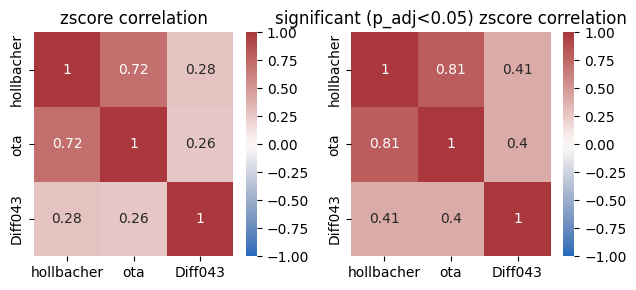

In [240]:
fig, ax = plt.subplots(1,2,figsize=(6.5,3))
sns.heatmap(combined_signatures[['zscore_hollbacher', 'zscore_ota', 'zscore_Diff043']].corr(),
            annot=True,
            center=0,
            xticklabels=['hollbacher', 'ota', 'Diff043'],
            yticklabels=['hollbacher', 'ota', 'Diff043'],
            cmap='vlag',
            vmin=-1,
            vmax=1,
            ax=ax[0])
ax[0].set_title('zscore correlation')

sns.heatmap(combined_signatures_signif[['zscore_hollbacher', 'zscore_ota', 'zscore_Diff043']].corr(),
            annot=True,
            center=0,
            xticklabels=['hollbacher', 'ota', 'Diff043'],
            yticklabels=['hollbacher', 'ota', 'Diff043'],
            cmap='vlag',
            vmin=-1,
            vmax=1,
            ax=ax[1])
ax[1].set_title('significant (p_adj<0.05) zscore correlation')

plt.tight_layout()

In [241]:
combined_signatures_signif

,gene_name,padj_hollbacher,zscore_hollbacher,padj_ota,zscore_ota,padj_Diff043,zscore_Diff043
0,TBX21,2.558741e-27,-11.590989,1.371920e-290,-36.630762,2.390809e-118,-23.439750
1,GZMK,2.735849e-17,-9.338291,0.000000e+00,-40.699941,4.680324e-08,-5.934091
2,LYAR,1.032448e-12,-8.098987,0.000000e+00,-58.090505,3.051003e-37,-13.136328
3,GNLY,2.320809e-11,-7.691574,2.762516e-83,-19.578501,2.475290e-38,-13.326088
4,EOMES,2.306847e-10,-7.374390,0.000000e+00,-40.299724,6.839965e-04,3.884069
...,...,...,...,...,...,...,...
1698,JUN,NaN,-0.313492,2.279293e-08,-5.955239,5.263910e-58,-16.405085
1699,NFKBID,NaN,0.202860,1.919595e-06,-5.139626,2.309610e-03,-3.535391
1700,RHOB,NaN,-0.196940,7.177238e-03,-3.096717,3.877044e-20,-9.610396
1701,RORC,NaN,-0.585678,7.178763e-17,-8.668179,9.588959e-06,-4.911131


In [242]:
combined_signatures.to_csv('results/combined_Th2_vs_Th1_signature.csv', index=False)